In [1]:
import os
import sys

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
!pip install pytorch-ood

In [2]:
import torch
import torch.nn as nn
import torchvision
import torch.optim as optim
import torchvision.transforms as tvt
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10, SVHN, Places365
from torchvision.transforms.functional import to_pil_image
import matplotlib.pyplot as plt
import random

from pytorch_ood.dataset.img import (
    LSUNCrop,
    LSUNResize,
    Textures,
    TinyImageNetCrop,
    TinyImageNetResize,
)
from pytorch_ood.detector import (
    ODIN,
    EnergyBased,
    Entropy,
    KLMatching,
    Mahalanobis,
    MaxLogit,
    MaxSoftmax,
    ViM,
    RMD,
    DICE,
    SHE,
)
from pytorch_ood.model import WideResNet
from pytorch_ood.utils import OODMetrics, ToRGB, ToUnknown

torch.manual_seed(1234)

mean = [x / 255 for x in [125.3, 123.0, 113.9]]
std = [x / 255 for x in [63.0, 62.1, 66.7]]

trans = tvt.Compose([
    tvt.Resize(size=(32, 32)),
    ToRGB(),
    tvt.ToTensor(),
    tvt.Normalize(std=std, mean=mean)
])

In [22]:
def calculate(test_loader, detector, name):
    metrics = OODMetrics() # Evaluate Detectors

    print("Total count:", len(test_loader))
    cnt = 0
    for x, y in test_loader:
        metrics.update(detector(x.cuda()), y)
        cnt += 1
        if (cnt + 1) % 50 == 0:
            print(f"[{cnt}/{len(test_loader)}]")

    r = metrics.compute()
    print()
    print(name)
    print(r)
    return r

In [4]:
CIFAR_test_dataset = CIFAR10(root="data", train=False, download=True, transform=trans)
CIFAR_test_loader = DataLoader(CIFAR_test_dataset, batch_size=128, num_workers=20)

def test(model):
    model.eval()
    benign_loss = 0
    adv_loss = 0
    benign_correct = 0
    adv_correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(CIFAR_test_loader):
            inputs, targets = inputs.cuda(), targets.cuda()
            total += targets.size(0)

            outputs = model(inputs)
            loss = criterion(outputs, targets)
            benign_loss += loss.item()

            _, predicted = outputs.max(1)
            benign_correct += predicted.eq(targets).sum().item()

            if batch_idx % 10 == 0:
                print('\nCurrent batch:', str(batch_idx))
                print('Current benign test accuracy:', str(predicted.eq(targets).sum().item() / targets.size(0)))
                print('Current benign test loss:', loss.item())

    print('Total benign test accuarcy:', 100. * benign_correct / total)
    print('Total benign test loss:', benign_loss)

Files already downloaded and verified


In [23]:
def evaluate(model):
    dataset_in_test = CIFAR10(root="data", train=False, download=True, transform=trans)
    loader_in_train = DataLoader(dataset_in_test, batch_size=128, num_workers=20)

    detector = MaxSoftmax(model)
    detector.fit(loader_in_train, device="cuda")

    result = []
    dataset_names = ["Textures", "LSUNCrop", "LSUNResize", "TinyImageNetCrop", "TinyImageNetResize", "SVHN", "Places365"]

    dataset_out_test = Textures(root="data", download=True, transform=trans, target_transform=ToUnknown())
    test_loader = DataLoader(dataset_in_test + dataset_out_test, batch_size=128, num_workers=20)
    result.append(calculate(test_loader, detector, dataset_names[0]))

    dataset_out_test = LSUNCrop(root="data", download=True, transform=trans, target_transform=ToUnknown())
    test_loader = DataLoader(dataset_in_test + dataset_out_test, batch_size=128, num_workers=20)
    result.append(calculate(test_loader, detector, dataset_names[1]))

    dataset_out_test = LSUNResize(root="data", download=True, transform=trans, target_transform=ToUnknown())
    test_loader = DataLoader(dataset_in_test + dataset_out_test, batch_size=128, num_workers=20)
    result.append(calculate(test_loader, detector, dataset_names[2]))

    dataset_out_test = TinyImageNetCrop(root="data", download=True, transform=trans, target_transform=ToUnknown())
    test_loader = DataLoader(dataset_in_test + dataset_out_test, batch_size=128, num_workers=20)
    result.append(calculate(test_loader, detector, dataset_names[3]))

    dataset_out_test = TinyImageNetResize(root="data", download=True, transform=trans, target_transform=ToUnknown())
    test_loader = DataLoader(dataset_in_test + dataset_out_test, batch_size=128, num_workers=20)
    result.append(calculate(test_loader, detector, dataset_names[4]))

    dataset_out_test = SVHN(root="data", split="test", download=True, transform=trans, target_transform=ToUnknown())
    test_loader = DataLoader(dataset_in_test + dataset_out_test, batch_size=128, num_workers=20)
    result.append(calculate(test_loader, detector, dataset_names[5]))

    dataset_out_test = Places365(root="data", split="val", small=True, transform=trans, target_transform=ToUnknown()) # , download=True)
    test_loader = DataLoader(dataset_in_test + dataset_out_test, batch_size=128, num_workers=20)
    result.append(calculate(test_loader, detector, dataset_names[6]))

    mean_AUROC = 0
    mean_FPR = 0
    for r in result:
        mean_AUROC += r["AUROC"] / len(result)
        mean_FPR += r["FPR95TPR"] / len(result)
    print("AUROC:", mean_AUROC)
    print("FPR:", mean_FPR)

### Multiple Input Mixup for Out-of-Distribution Detection (MIM)

In [9]:
def MixUp(inputs):
    batch_size = inputs.size(0)
    index = [torch.randperm(batch_size) for _ in range(mix_size)]

    mixed_input = torch.zeros_like(inputs)
    for i in range(batch_size):
        for j in range(mix_size):
            mixed_input[i] += inputs[index[j][i], :] / mix_size

    return mixed_input

def unnormalize(tensor, mean, std):
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)    
    return tensor

In [11]:
new_trans = tvt.Compose([
    tvt.Resize(size=(32, 32)),
    ToRGB(),
    tvt.ColorJitter(brightness=0.5, contrast=0.3, saturation=0.3, hue=0.3),  # Random color jitter
    tvt.RandomAffine((-90,90), translate=(0.2, 0.2)),
    tvt.ToTensor(),
    tvt.Normalize(std=std, mean=mean)
])

Files already downloaded and verified
Files already downloaded and verified


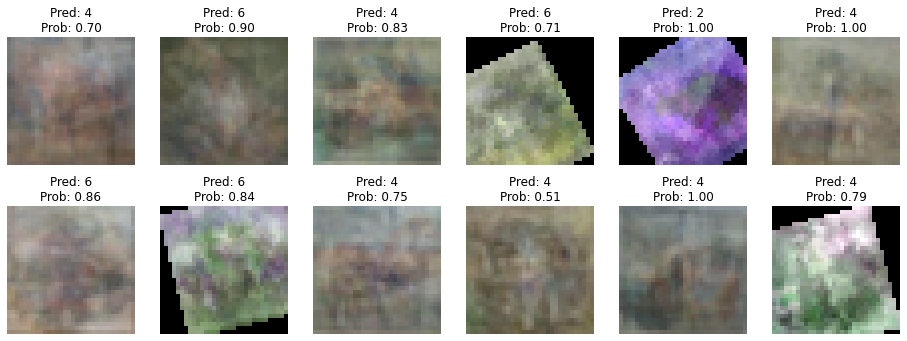

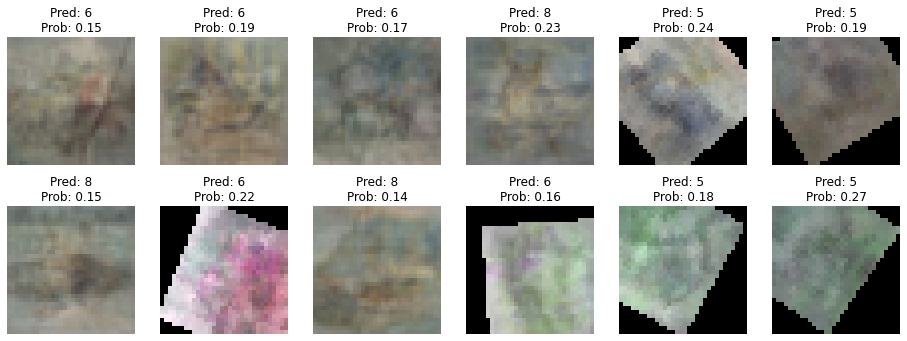


Current batch: 30
Current adversarial train accuracy: 0.9609375
Current adversarial train loss: 0.15990187227725983
Files already downloaded and verified
Total count: 123
[49/123]
[99/123]

Textures
{'AUROC': 0.9324254393577576, 'AUPR-IN': 0.8798916339874268, 'AUPR-OUT': 0.9616314172744751, 'FPR95TPR': 0.271699994802475}
Total count: 157
[49/157]
[99/157]
[149/157]

LSUNCrop
{'AUROC': 0.9908587336540222, 'AUPR-IN': 0.9883297681808472, 'AUPR-OUT': 0.9927008748054504, 'FPR95TPR': 0.033900000154972076}
Total count: 157
[49/157]
[99/157]
[149/157]

LSUNResize
{'AUROC': 0.9238269329071045, 'AUPR-IN': 0.8943201899528503, 'AUPR-OUT': 0.9443157911300659, 'FPR95TPR': 0.2079000025987625}
Total count: 157
[49/157]
[99/157]
[149/157]

TinyImageNetCrop
{'AUROC': 0.9810452461242676, 'AUPR-IN': 0.9780184030532837, 'AUPR-OUT': 0.984101414680481, 'FPR95TPR': 0.08389999717473984}
Total count: 157
[49/157]
[99/157]
[149/157]

TinyImageNetResize
{'AUROC': 0.9153730273246765, 'AUPR-IN': 0.885320782661438,

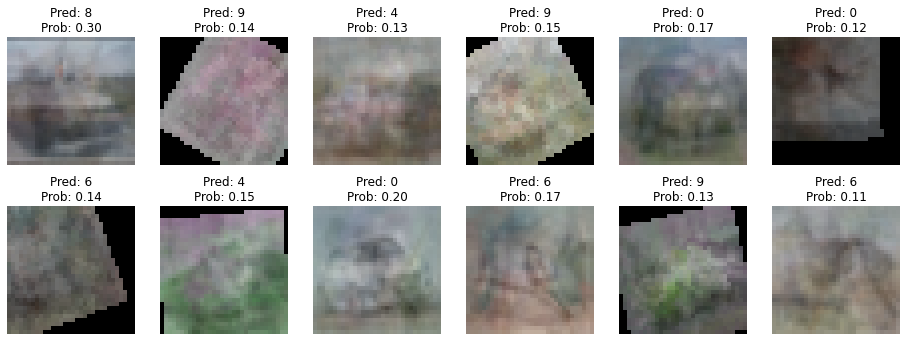


Current batch: 60
Current adversarial train accuracy: 1.0
Current adversarial train loss: 0.03271980956196785
Files already downloaded and verified
Total count: 123
[49/123]
[99/123]

Textures
{'AUROC': 0.9536693096160889, 'AUPR-IN': 0.9258931875228882, 'AUPR-OUT': 0.9725156426429749, 'FPR95TPR': 0.20739999413490295}
Total count: 157
[49/157]
[99/157]
[149/157]

LSUNCrop
{'AUROC': 0.9954433441162109, 'AUPR-IN': 0.9949327707290649, 'AUPR-OUT': 0.995867908000946, 'FPR95TPR': 0.02019999921321869}
Total count: 157
[49/157]
[99/157]
[149/157]

LSUNResize
{'AUROC': 0.9577807784080505, 'AUPR-IN': 0.9468216300010681, 'AUPR-OUT': 0.9668521881103516, 'FPR95TPR': 0.14560000598430634}
Total count: 157
[49/157]
[99/157]
[149/157]

TinyImageNetCrop
{'AUROC': 0.9871312975883484, 'AUPR-IN': 0.9863149523735046, 'AUPR-OUT': 0.9883170127868652, 'FPR95TPR': 0.06949999928474426}
Total count: 157
[49/157]
[99/157]
[149/157]

TinyImageNetResize
{'AUROC': 0.9460759162902832, 'AUPR-IN': 0.9331661462783813, 'A

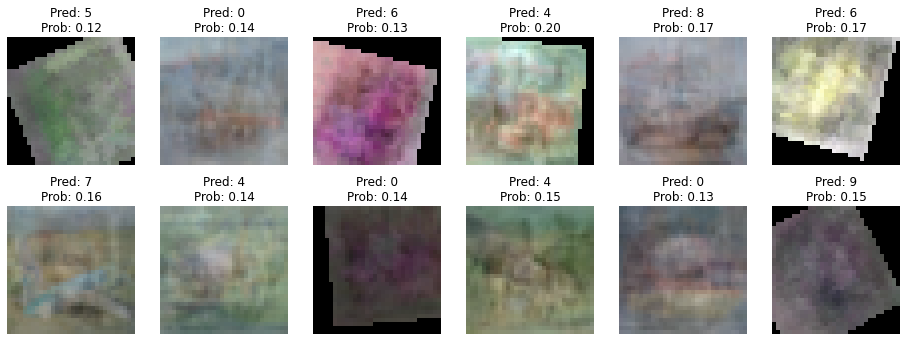


Current batch: 90
Current adversarial train accuracy: 0.9921875
Current adversarial train loss: 0.028798844665288925
Files already downloaded and verified
Total count: 123
[49/123]
[99/123]

Textures
{'AUROC': 0.9576249718666077, 'AUPR-IN': 0.9321562051773071, 'AUPR-OUT': 0.9748719334602356, 'FPR95TPR': 0.19179999828338623}
Total count: 157
[49/157]
[99/157]
[149/157]

LSUNCrop
{'AUROC': 0.995730996131897, 'AUPR-IN': 0.9954147338867188, 'AUPR-OUT': 0.9960629940032959, 'FPR95TPR': 0.0210999995470047}
Total count: 157
[49/157]
[99/157]
[149/157]

LSUNResize
{'AUROC': 0.9624554514884949, 'AUPR-IN': 0.9530059099197388, 'AUPR-OUT': 0.9702454209327698, 'FPR95TPR': 0.13089999556541443}
Total count: 157
[49/157]
[99/157]
[149/157]

TinyImageNetCrop
{'AUROC': 0.9876915216445923, 'AUPR-IN': 0.9870019555091858, 'AUPR-OUT': 0.9888231158256531, 'FPR95TPR': 0.06729999929666519}
Total count: 157
[49/157]
[99/157]
[149/157]

TinyImageNetResize
{'AUROC': 0.9515243768692017, 'AUPR-IN': 0.94056749343872

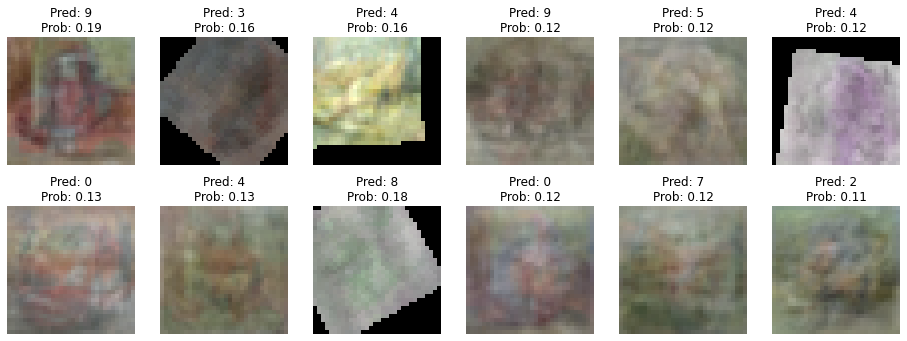


Current batch: 120
Current adversarial train accuracy: 0.984375
Current adversarial train loss: 0.037945330142974854
Files already downloaded and verified
Total count: 123
[49/123]
[99/123]

Textures
{'AUROC': 0.9600117802619934, 'AUPR-IN': 0.9364030957221985, 'AUPR-OUT': 0.9761314988136292, 'FPR95TPR': 0.1851000040769577}
Total count: 157
[49/157]
[99/157]
[149/157]

LSUNCrop
{'AUROC': 0.995730459690094, 'AUPR-IN': 0.9954795837402344, 'AUPR-OUT': 0.9960361123085022, 'FPR95TPR': 0.02199999988079071}
Total count: 157
[49/157]
[99/157]
[149/157]

LSUNResize
{'AUROC': 0.9679262638092041, 'AUPR-IN': 0.9605793952941895, 'AUPR-OUT': 0.9741431474685669, 'FPR95TPR': 0.11919999867677689}
Total count: 157
[49/157]
[99/157]
[149/157]

TinyImageNetCrop
{'AUROC': 0.9881739616394043, 'AUPR-IN': 0.9876290559768677, 'AUPR-OUT': 0.9892145395278931, 'FPR95TPR': 0.06499999761581421}
Total count: 157
[49/157]
[99/157]
[149/157]

TinyImageNetResize
{'AUROC': 0.9577130675315857, 'AUPR-IN': 0.94912880659103

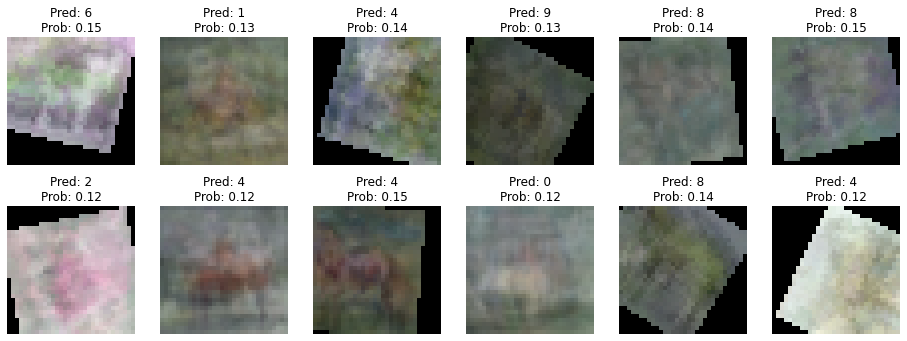


Current batch: 150
Current adversarial train accuracy: 0.9921875
Current adversarial train loss: 0.02906099148094654
Files already downloaded and verified
Total count: 123
[49/123]
[99/123]

Textures
{'AUROC': 0.9602416753768921, 'AUPR-IN': 0.937152087688446, 'AUPR-OUT': 0.976142406463623, 'FPR95TPR': 0.1868000030517578}
Total count: 157
[49/157]
[99/157]
[149/157]

LSUNCrop
{'AUROC': 0.9957736730575562, 'AUPR-IN': 0.9955122470855713, 'AUPR-OUT': 0.9960688352584839, 'FPR95TPR': 0.021299999207258224}
Total count: 157
[49/157]
[99/157]
[149/157]

LSUNResize
{'AUROC': 0.9695113897323608, 'AUPR-IN': 0.9623472690582275, 'AUPR-OUT': 0.9753949642181396, 'FPR95TPR': 0.1145000010728836}
Total count: 157
[49/157]
[99/157]
[149/157]

TinyImageNetCrop
{'AUROC': 0.9880615472793579, 'AUPR-IN': 0.9874839782714844, 'AUPR-OUT': 0.9891104102134705, 'FPR95TPR': 0.06629999727010727}
Total count: 157
[49/157]
[99/157]
[149/157]

TinyImageNetResize
{'AUROC': 0.9591569304466248, 'AUPR-IN': 0.950868368148803

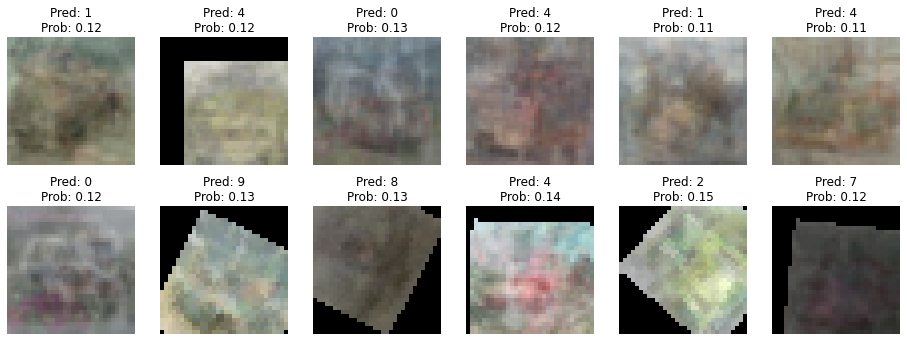


Current batch: 180
Current adversarial train accuracy: 1.0
Current adversarial train loss: 0.027932042255997658
Files already downloaded and verified
Total count: 123
[49/123]
[99/123]

Textures
{'AUROC': 0.961110532283783, 'AUPR-IN': 0.9387412071228027, 'AUPR-OUT': 0.9765574336051941, 'FPR95TPR': 0.18479999899864197}
Total count: 157
[49/157]
[99/157]
[149/157]

LSUNCrop
{'AUROC': 0.995733380317688, 'AUPR-IN': 0.9955167770385742, 'AUPR-OUT': 0.9960153102874756, 'FPR95TPR': 0.023099999874830246}
Total count: 157
[49/157]
[99/157]
[149/157]

LSUNResize
{'AUROC': 0.9709034562110901, 'AUPR-IN': 0.9643179774284363, 'AUPR-OUT': 0.9763950705528259, 'FPR95TPR': 0.11140000075101852}
Total count: 157
[49/157]
[99/157]
[149/157]

TinyImageNetCrop
{'AUROC': 0.9881187677383423, 'AUPR-IN': 0.9875944256782532, 'AUPR-OUT': 0.9891501665115356, 'FPR95TPR': 0.06610000133514404}
Total count: 157
[49/157]
[99/157]
[149/157]

TinyImageNetResize
{'AUROC': 0.9610984325408936, 'AUPR-IN': 0.953582763671875, '

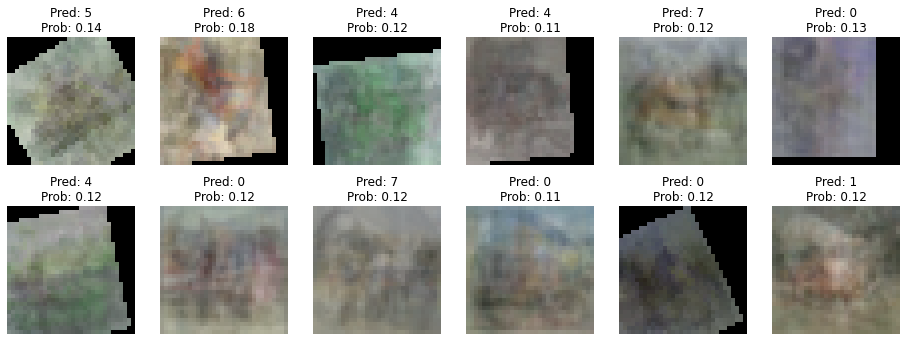


Current batch: 210
Current adversarial train accuracy: 1.0
Current adversarial train loss: 0.014077316969633102
Files already downloaded and verified
Total count: 123
[49/123]
[99/123]

Textures
{'AUROC': 0.9614782929420471, 'AUPR-IN': 0.9395401477813721, 'AUPR-OUT': 0.9766806364059448, 'FPR95TPR': 0.18359999358654022}
Total count: 157
[49/157]
[99/157]
[149/157]

LSUNCrop
{'AUROC': 0.9957560896873474, 'AUPR-IN': 0.9955321550369263, 'AUPR-OUT': 0.9960406422615051, 'FPR95TPR': 0.02239999920129776}
Total count: 157
[49/157]
[99/157]
[149/157]

LSUNResize
{'AUROC': 0.9718748331069946, 'AUPR-IN': 0.9653919339179993, 'AUPR-OUT': 0.9771541357040405, 'FPR95TPR': 0.10819999873638153}
Total count: 157
[49/157]
[99/157]
[149/157]

TinyImageNetCrop
{'AUROC': 0.988186240196228, 'AUPR-IN': 0.987658679485321, 'AUPR-OUT': 0.9892061352729797, 'FPR95TPR': 0.06560000032186508}
Total count: 157
[49/157]
[99/157]
[149/157]

TinyImageNetResize
{'AUROC': 0.9621543884277344, 'AUPR-IN': 0.9549059867858887, '

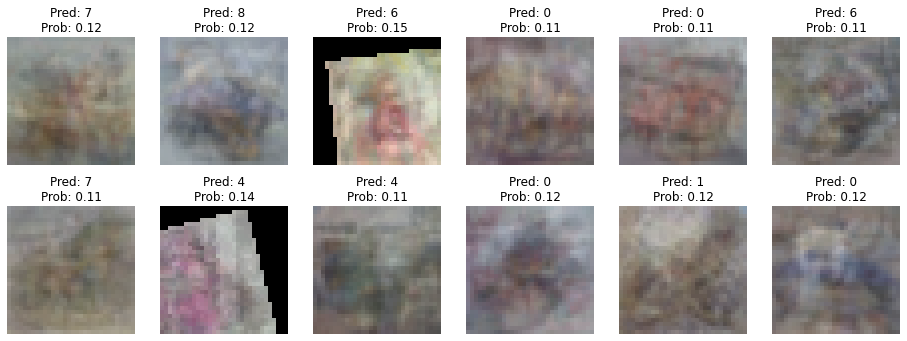


Current batch: 240
Current adversarial train accuracy: 0.9921875
Current adversarial train loss: 0.04035287722945213
Files already downloaded and verified
Total count: 123
[49/123]
[99/123]

Textures
{'AUROC': 0.9619775414466858, 'AUPR-IN': 0.9405094981193542, 'AUPR-OUT': 0.9768855571746826, 'FPR95TPR': 0.18320000171661377}
Total count: 157
[49/157]
[99/157]
[149/157]

LSUNCrop
{'AUROC': 0.9956279397010803, 'AUPR-IN': 0.9953850507736206, 'AUPR-OUT': 0.9959286451339722, 'FPR95TPR': 0.024299999698996544}
Total count: 157
[49/157]
[99/157]
[149/157]

LSUNResize
{'AUROC': 0.9728020429611206, 'AUPR-IN': 0.9665939807891846, 'AUPR-OUT': 0.9777915477752686, 'FPR95TPR': 0.10620000213384628}
Total count: 157
[49/157]
[99/157]
[149/157]

TinyImageNetCrop
{'AUROC': 0.9879322648048401, 'AUPR-IN': 0.9873833060264587, 'AUPR-OUT': 0.9889842867851257, 'FPR95TPR': 0.06689999997615814}
Total count: 157
[49/157]
[99/157]
[149/157]

TinyImageNetResize
{'AUROC': 0.9631217122077942, 'AUPR-IN': 0.95623654127

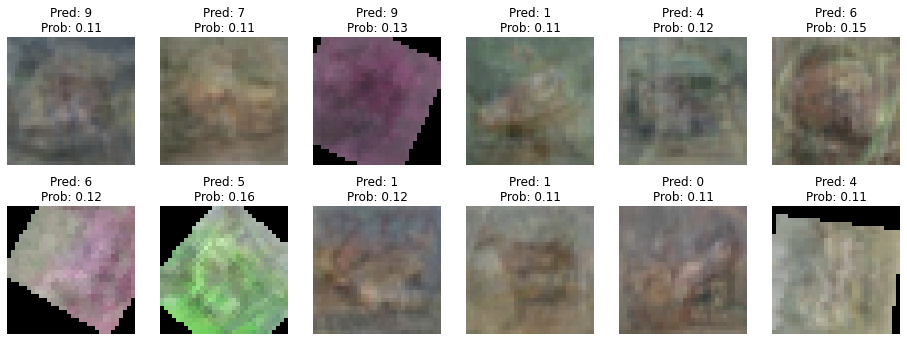


Current batch: 270
Current adversarial train accuracy: 0.9921875
Current adversarial train loss: 0.03753894940018654
Files already downloaded and verified
Total count: 123
[49/123]
[99/123]

Textures
{'AUROC': 0.9621855020523071, 'AUPR-IN': 0.9408257603645325, 'AUPR-OUT': 0.9770001769065857, 'FPR95TPR': 0.18289999663829803}
Total count: 157
[49/157]
[99/157]
[149/157]

LSUNCrop
{'AUROC': 0.9955881834030151, 'AUPR-IN': 0.9954067468643188, 'AUPR-OUT': 0.995871365070343, 'FPR95TPR': 0.025100000202655792}
Total count: 157
[49/157]
[99/157]
[149/157]

LSUNResize
{'AUROC': 0.9728496074676514, 'AUPR-IN': 0.9668008089065552, 'AUPR-OUT': 0.9778474569320679, 'FPR95TPR': 0.10580000281333923}
Total count: 157
[49/157]
[99/157]
[149/157]

TinyImageNetCrop
{'AUROC': 0.9878256320953369, 'AUPR-IN': 0.9872993230819702, 'AUPR-OUT': 0.9889060258865356, 'FPR95TPR': 0.06639999896287918}
Total count: 157
[49/157]
[99/157]
[149/157]

TinyImageNetResize
{'AUROC': 0.9629035592079163, 'AUPR-IN': 0.956120491027

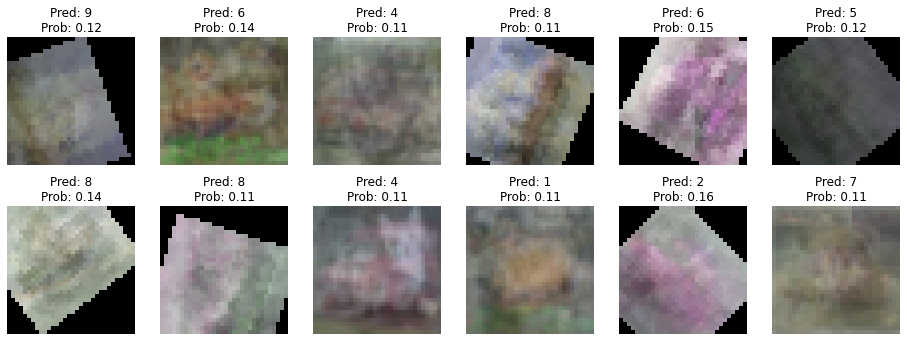


Current batch: 300
Current adversarial train accuracy: 1.0
Current adversarial train loss: 0.02777496911585331
Files already downloaded and verified
Total count: 123
[49/123]
[99/123]

Textures
{'AUROC': 0.9620027542114258, 'AUPR-IN': 0.9405979514122009, 'AUPR-OUT': 0.9768352508544922, 'FPR95TPR': 0.18070000410079956}
Total count: 157
[49/157]
[99/157]
[149/157]

LSUNCrop
{'AUROC': 0.9955097436904907, 'AUPR-IN': 0.9952957630157471, 'AUPR-OUT': 0.9958036541938782, 'FPR95TPR': 0.025299999862909317}
Total count: 157
[49/157]
[99/157]
[149/157]

LSUNResize
{'AUROC': 0.9731419086456299, 'AUPR-IN': 0.9670940637588501, 'AUPR-OUT': 0.9780727028846741, 'FPR95TPR': 0.10490000247955322}
Total count: 157
[49/157]
[99/157]
[149/157]

TinyImageNetCrop
{'AUROC': 0.9877290725708008, 'AUPR-IN': 0.9871542453765869, 'AUPR-OUT': 0.9888379573822021, 'FPR95TPR': 0.06689999997615814}
Total count: 157
[49/157]
[99/157]
[149/157]

TinyImageNetResize
{'AUROC': 0.9630733132362366, 'AUPR-IN': 0.956379771232605, 

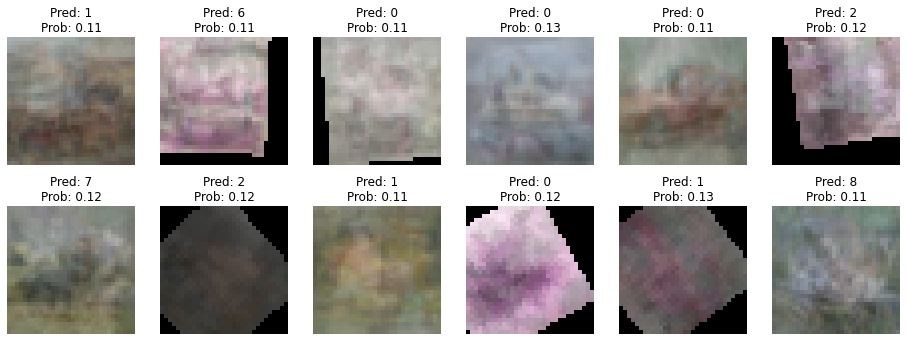


Current batch: 330
Current adversarial train accuracy: 1.0
Current adversarial train loss: 0.011326801963150501
Files already downloaded and verified
Total count: 123
[49/123]
[99/123]

Textures
{'AUROC': 0.9619156122207642, 'AUPR-IN': 0.9405933618545532, 'AUPR-OUT': 0.976765513420105, 'FPR95TPR': 0.1818999946117401}
Total count: 157
[49/157]
[99/157]
[149/157]

LSUNCrop
{'AUROC': 0.9953805208206177, 'AUPR-IN': 0.9951695203781128, 'AUPR-OUT': 0.995682954788208, 'FPR95TPR': 0.027899999171495438}
Total count: 157
[49/157]
[99/157]
[149/157]

LSUNResize
{'AUROC': 0.9736524224281311, 'AUPR-IN': 0.9677146077156067, 'AUPR-OUT': 0.9784712195396423, 'FPR95TPR': 0.10339999943971634}
Total count: 157
[49/157]
[99/157]
[149/157]

TinyImageNetCrop
{'AUROC': 0.9875107407569885, 'AUPR-IN': 0.9869009256362915, 'AUPR-OUT': 0.9886681437492371, 'FPR95TPR': 0.06759999692440033}
Total count: 157
[49/157]
[99/157]
[149/157]

TinyImageNetResize
{'AUROC': 0.9635452628135681, 'AUPR-IN': 0.9569606184959412, '

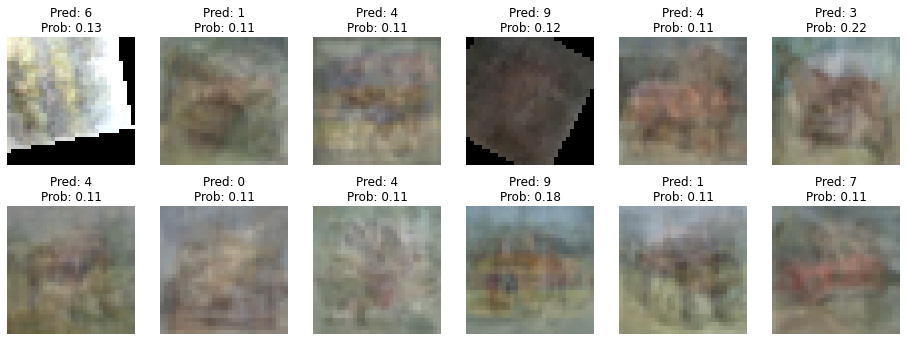


Current batch: 360
Current adversarial train accuracy: 1.0
Current adversarial train loss: 0.006803274154663086
Files already downloaded and verified
Total count: 123
[49/123]
[99/123]

Textures
{'AUROC': 0.9616768956184387, 'AUPR-IN': 0.9403799176216125, 'AUPR-OUT': 0.9765758514404297, 'FPR95TPR': 0.18389999866485596}
Total count: 157
[49/157]
[99/157]
[149/157]

LSUNCrop
{'AUROC': 0.995130717754364, 'AUPR-IN': 0.9949195384979248, 'AUPR-OUT': 0.9954473972320557, 'FPR95TPR': 0.03020000085234642}
Total count: 157
[49/157]
[99/157]
[149/157]

LSUNResize
{'AUROC': 0.9735715389251709, 'AUPR-IN': 0.9676582217216492, 'AUPR-OUT': 0.9784056544303894, 'FPR95TPR': 0.10279999673366547}
Total count: 157
[49/157]
[99/157]
[149/157]

TinyImageNetCrop
{'AUROC': 0.9869556427001953, 'AUPR-IN': 0.9863166809082031, 'AUPR-OUT': 0.9881828427314758, 'FPR95TPR': 0.07090000063180923}
Total count: 157
[49/157]
[99/157]
[149/157]

TinyImageNetResize
{'AUROC': 0.9632030725479126, 'AUPR-IN': 0.9566248059272766, 

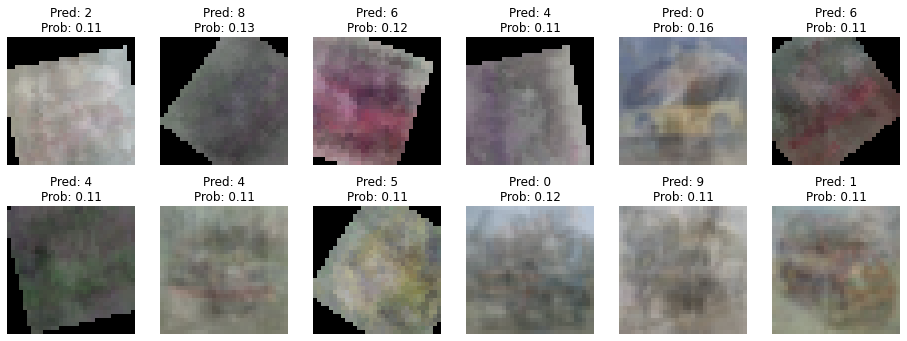


Current batch: 390
Current adversarial train accuracy: 0.9875
Current adversarial train loss: 0.045655615627765656
Files already downloaded and verified
Total count: 123
[49/123]
[99/123]

Textures
{'AUROC': 0.9623855352401733, 'AUPR-IN': 0.9414675235748291, 'AUPR-OUT': 0.9769219756126404, 'FPR95TPR': 0.18250000476837158}
Total count: 157
[49/157]
[99/157]
[149/157]

LSUNCrop
{'AUROC': 0.9952558279037476, 'AUPR-IN': 0.9950128793716431, 'AUPR-OUT': 0.9955766797065735, 'FPR95TPR': 0.029100000858306885}
Total count: 157
[49/157]
[99/157]
[149/157]

LSUNResize
{'AUROC': 0.9746218919754028, 'AUPR-IN': 0.9688540697097778, 'AUPR-OUT': 0.9791842699050903, 'FPR95TPR': 0.10080000013113022}
Total count: 157
[49/157]
[99/157]
[149/157]

TinyImageNetCrop
{'AUROC': 0.9872820973396301, 'AUPR-IN': 0.9866279363632202, 'AUPR-OUT': 0.9884741306304932, 'FPR95TPR': 0.06800000369548798}
Total count: 157
[49/157]
[99/157]
[149/157]

TinyImageNetResize
{'AUROC': 0.9646652936935425, 'AUPR-IN': 0.9583988189697

In [25]:
model = WideResNet(num_classes=10, pretrained="cifar10-pt").cuda().eval()
mix_size = 10

train_loss = 0
correct = 0
total = 0
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)

CIFAR_train_dataset = CIFAR10(root="data", train=True, download=True, transform=trans)
CIFAR_train_loader = DataLoader(CIFAR_train_dataset, batch_size=128, num_workers=20)

CIFAR_train_dataset_mix = CIFAR10(root="data", train=True, download=True, transform=new_trans)
CIFAR_train_loader_mix = DataLoader(CIFAR_train_dataset, batch_size=128, num_workers=20)

original_confidences = []
mixed_confidences = []
num_epoch = 1

for epoch in range(num_epoch):
    log_step = 30
    for batch_idx, ((inputs, targets), (inputs_mix, targets_mix)) in enumerate(zip(CIFAR_train_loader, CIFAR_train_loader_mix)):

        inputs, targets = inputs.cuda(), targets.cuda()
        inputs_mix, targets_mix = inputs_mix.cuda(), targets_mix.cuda()
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, targets)

        train_loss += loss.item()
        _, predicted = outputs.max(1)

        original_prob = torch.softmax(outputs, dim=1).max(1)[0].detach().cpu().numpy()
        original_confidences.append(original_prob)

        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        mixed_input = MixUp(inputs_mix)
        for i in range(inputs.size(0)):
            x = random.randint(1, 2)
            if x == 1:
                mixed_input_pil = to_pil_image(unnormalize(mixed_input[i], mean, std))
                mixed_input[i] = new_trans(mixed_input_pil)

        mixed_outputs = model(mixed_input)
        _, mixed_preds = torch.max(mixed_outputs.data, 1)

        mixed_prob = torch.max(torch.softmax(mixed_outputs[0], dim=0)).item()
        mixed_confidences.append(mixed_prob)

        if batch_idx % log_step == 0:
            plt.figure(figsize=(16, 5.7))
            for i in range(12):
                img = mixed_input[i].cpu()
                img = unnormalize(img, mean, std)
                img = img.numpy().transpose((1, 2, 0))
                predicted_label = mixed_preds[i].item()  
                predicted_prob = torch.max(torch.softmax(mixed_outputs[i], dim=0)).item()  
                plt.subplot(2, 6, i+1)
                plt.imshow(img)
                plt.title(f"Pred: {predicted_label}\nProb: {predicted_prob:.2f}")
                plt.axis('off')
            plt.show()

        batch_size = inputs.size(0)
        uniform_labels = torch.ones((batch_size, 10), dtype=torch.int64).cuda() / 10
        uniform_loss = criterion(mixed_outputs, uniform_labels).cuda()

        total_loss = loss + uniform_loss
        total_loss.backward()

        optimizer.step()

        if batch_idx != 0 and batch_idx % 30 == 0:
            print('\nCurrent batch:', str(batch_idx))
            print('Current adversarial train accuracy:', str(predicted.eq(targets).sum().item() / targets.size(0)))
            print('Current adversarial train loss:', loss.item())
            evaluate(model)
            test(model)
evaluate(model)

### Other Methods

#### MSP

In [26]:
model = WideResNet(num_classes=10, pretrained="cifar10-pt").cuda().eval()

dataset_in_test = CIFAR10(root="data", train=False, download=True, transform=trans)
loader_in_train = DataLoader(dataset_in_test, batch_size=128, num_workers=20)

detector = MaxSoftmax(model)
detector.fit(loader_in_train, device="cuda")
dataset_names = ["Textures", "LSUNCrop", "LSUNResize", "TinyImageNetCrop", "TinyImageNetResize", "SVHN", "Places365"]

result = []

dataset_out_test = Textures(root="data", download=True, transform=trans, target_transform=ToUnknown())
test_loader = DataLoader(dataset_in_test + dataset_out_test, batch_size=128, num_workers=20)
result.append(calculate(test_loader, detector, dataset_names[0]))

dataset_out_test = LSUNCrop(root="data", download=True, transform=trans, target_transform=ToUnknown())
test_loader = DataLoader(dataset_in_test + dataset_out_test, batch_size=128, num_workers=20)
result.append(calculate(test_loader, detector, dataset_names[1]))

dataset_out_test = LSUNResize(root="data", download=True, transform=trans, target_transform=ToUnknown())
test_loader = DataLoader(dataset_in_test + dataset_out_test, batch_size=128, num_workers=20)
result.append(calculate(test_loader, detector, dataset_names[2]))

dataset_out_test = TinyImageNetCrop(root="data", download=True, transform=trans, target_transform=ToUnknown())
test_loader = DataLoader(dataset_in_test + dataset_out_test, batch_size=128, num_workers=20)
result.append(calculate(test_loader, detector, dataset_names[3]))

dataset_out_test = TinyImageNetResize(root="data", download=True, transform=trans, target_transform=ToUnknown())
test_loader = DataLoader(dataset_in_test + dataset_out_test, batch_size=128, num_workers=20)
result.append(calculate(test_loader, detector, dataset_names[4]))

dataset_out_test = SVHN(root="data", split="test", download=True, transform=trans, target_transform=ToUnknown())
test_loader = DataLoader(dataset_in_test + dataset_out_test, batch_size=128, num_workers=20)
result.append(calculate(test_loader, detector, dataset_names[5]))

dataset_out_test = Places365(root="data", split="val", small=True, transform=trans, target_transform=ToUnknown())
test_loader = DataLoader(dataset_in_test + dataset_out_test, batch_size=128, num_workers=20)
result.append(calculate(test_loader, detector, dataset_names[6]))

mean_AUROC = 0
mean_FPR = 0
for r in result:
    mean_AUROC += r["AUROC"] / len(result)
    mean_FPR += r["FPR95TPR"] / len(result)
print("AUROC:", mean_AUROC)
print("FPR:", mean_FPR)

Files already downloaded and verified
Total count: 123
[49/123]
[99/123]

Textures
{'AUROC': 0.8851455450057983, 'AUPR-IN': 0.7850015163421631, 'AUPR-OUT': 0.9299275875091553, 'FPR95TPR': 0.40860000252723694}
Total count: 157
[49/157]
[99/157]
[149/157]

LSUNCrop
{'AUROC': 0.9648686051368713, 'AUPR-IN': 0.9568921327590942, 'AUPR-OUT': 0.9720240831375122, 'FPR95TPR': 0.12489999830722809}
Total count: 157
[49/157]
[99/157]
[149/157]

LSUNResize
{'AUROC': 0.9145042896270752, 'AUPR-IN': 0.8946420550346375, 'AUPR-OUT': 0.9264611005783081, 'FPR95TPR': 0.2906000018119812}
Total count: 157
[49/157]
[99/157]
[149/157]

TinyImageNetCrop
{'AUROC': 0.9459179043769836, 'AUPR-IN': 0.9310121536254883, 'AUPR-OUT': 0.9577121734619141, 'FPR95TPR': 0.17170000076293945}
Total count: 157
[49/157]
[99/157]
[149/157]

TinyImageNetResize
{'AUROC': 0.8822128772735596, 'AUPR-IN': 0.8600499629974365, 'AUPR-OUT': 0.8924695253372192, 'FPR95TPR': 0.42559999227523804}
Using downloaded and verified file: data/test_32

#### ODIN

In [27]:
model = WideResNet(num_classes=10, pretrained="cifar10-pt").cuda().eval()

dataset_in_test = CIFAR10(root="data", train=False, download=True, transform=trans)
loader_in_train = DataLoader(dataset_in_test, batch_size=128, num_workers=20)

detector = ODIN(model, eps=0.002)
detector.fit(loader_in_train, device="cuda")

dataset_names = ["Textures", "LSUNCrop", "LSUNResize", "TinyImageNetCrop", "TinyImageNetResize", "SVHN", "Places365"]

result = []

dataset_out_test = Textures(root="data", download=True, transform=trans, target_transform=ToUnknown())
test_loader = DataLoader(dataset_in_test + dataset_out_test, batch_size=128, num_workers=20)
result.append(calculate(test_loader, detector, dataset_names[0]))

dataset_out_test = LSUNCrop(root="data", download=True, transform=trans, target_transform=ToUnknown())
test_loader = DataLoader(dataset_in_test + dataset_out_test, batch_size=128, num_workers=20)
result.append(calculate(test_loader, detector, dataset_names[1]))

dataset_out_test = LSUNResize(root="data", download=True, transform=trans, target_transform=ToUnknown())
test_loader = DataLoader(dataset_in_test + dataset_out_test, batch_size=128, num_workers=20)
result.append(calculate(test_loader, detector, dataset_names[2]))

dataset_out_test = TinyImageNetCrop(root="data", download=True, transform=trans, target_transform=ToUnknown())
test_loader = DataLoader(dataset_in_test + dataset_out_test, batch_size=128, num_workers=20)
result.append(calculate(test_loader, detector, dataset_names[3]))

dataset_out_test = TinyImageNetResize(root="data", download=True, transform=trans, target_transform=ToUnknown())
test_loader = DataLoader(dataset_in_test + dataset_out_test, batch_size=128, num_workers=20)
result.append(calculate(test_loader, detector, dataset_names[4]))

dataset_out_test = SVHN(root="data", split="test", download=True, transform=trans, target_transform=ToUnknown())
test_loader = DataLoader(dataset_in_test + dataset_out_test, batch_size=128, num_workers=20)
result.append(calculate(test_loader, detector, dataset_names[5]))

dataset_out_test = Places365(root="data", split="val", small=True, transform=trans, target_transform=ToUnknown())
test_loader = DataLoader(dataset_in_test + dataset_out_test, batch_size=128, num_workers=20)
result.append(calculate(test_loader, detector, dataset_names[6]))

mean_AUROC = 0
mean_FPR = 0
for r in result:
    mean_AUROC += r["AUROC"] / len(result)
    mean_FPR += r["FPR95TPR"] / len(result)
print("AUROC:", mean_AUROC)
print("FPR:", mean_FPR)

Files already downloaded and verified
Total count: 123
[49/123]
[99/123]

Textures
{'AUROC': 0.8835126161575317, 'AUPR-IN': 0.8070477843284607, 'AUPR-OUT': 0.9239557981491089, 'FPR95TPR': 0.4814999997615814}
Total count: 157
[49/157]
[99/157]
[149/157]

LSUNCrop
{'AUROC': 0.9748983383178711, 'AUPR-IN': 0.9730664491653442, 'AUPR-OUT': 0.978147566318512, 'FPR95TPR': 0.11389999836683273}
Total count: 157
[49/157]
[99/157]
[149/157]

LSUNResize
{'AUROC': 0.9314399361610413, 'AUPR-IN': 0.9253137111663818, 'AUPR-OUT': 0.9374159574508667, 'FPR95TPR': 0.2720000147819519}
Total count: 157
[49/157]
[99/157]
[149/157]

TinyImageNetCrop
{'AUROC': 0.9580069184303284, 'AUPR-IN': 0.9518743753433228, 'AUPR-OUT': 0.9649056196212769, 'FPR95TPR': 0.15440000593662262}
Total count: 157
[49/157]
[99/157]
[149/157]

TinyImageNetResize
{'AUROC': 0.8986509442329407, 'AUPR-IN': 0.8913910388946533, 'AUPR-OUT': 0.9041488170623779, 'FPR95TPR': 0.4041000008583069}
Using downloaded and verified file: data/test_32x32

#### Mahalanobis

In [28]:
model = WideResNet(num_classes=10, pretrained="cifar10-pt").cuda().eval()

dataset_in_test = CIFAR10(root="data", train=False, download=True, transform=trans)
loader_in_train = DataLoader(dataset_in_test, batch_size=128, num_workers=20)

detector = Mahalanobis(model.features)
detector.fit(loader_in_train, device="cuda")

dataset_names = ["Textures", "LSUNCrop", "LSUNResize", "TinyImageNetCrop", "TinyImageNetResize", "SVHN", "Places365"]

result = []

dataset_out_test = Textures(root="data", download=True, transform=trans, target_transform=ToUnknown())
test_loader = DataLoader(dataset_in_test + dataset_out_test, batch_size=128, num_workers=20)
result.append(calculate(test_loader, detector, dataset_names[0]))

dataset_out_test = LSUNCrop(root="data", download=True, transform=trans, target_transform=ToUnknown())
test_loader = DataLoader(dataset_in_test + dataset_out_test, batch_size=128, num_workers=20)
result.append(calculate(test_loader, detector, dataset_names[1]))

dataset_out_test = LSUNResize(root="data", download=True, transform=trans, target_transform=ToUnknown())
test_loader = DataLoader(dataset_in_test + dataset_out_test, batch_size=128, num_workers=20)
result.append(calculate(test_loader, detector, dataset_names[2]))

dataset_out_test = TinyImageNetCrop(root="data", download=True, transform=trans, target_transform=ToUnknown())
test_loader = DataLoader(dataset_in_test + dataset_out_test, batch_size=128, num_workers=20)
result.append(calculate(test_loader, detector, dataset_names[3]))

dataset_out_test = TinyImageNetResize(root="data", download=True, transform=trans, target_transform=ToUnknown())
test_loader = DataLoader(dataset_in_test + dataset_out_test, batch_size=128, num_workers=20)
result.append(calculate(test_loader, detector, dataset_names[4]))

dataset_out_test = SVHN(root="data", split="test", download=True, transform=trans, target_transform=ToUnknown())
test_loader = DataLoader(dataset_in_test + dataset_out_test, batch_size=128, num_workers=20)
result.append(calculate(test_loader, detector, dataset_names[5]))

dataset_out_test = Places365(root="data", split="val", small=True, transform=trans, target_transform=ToUnknown())
test_loader = DataLoader(dataset_in_test + dataset_out_test, batch_size=128, num_workers=20)
result.append(calculate(test_loader, detector, dataset_names[6]))

mean_AUROC = 0
mean_FPR = 0
for r in result:
    mean_AUROC += r["AUROC"] / len(result)
    mean_FPR += r["FPR95TPR"] / len(result)
print("AUROC:", mean_AUROC)
print("FPR:", mean_FPR)

Files already downloaded and verified
Total count: 123
[49/123]
[99/123]

Textures
{'AUROC': 0.9626646041870117, 'AUPR-IN': 0.9454846382141113, 'AUPR-OUT': 0.977156937122345, 'FPR95TPR': 0.20589999854564667}
Total count: 157
[49/157]
[99/157]
[149/157]

LSUNCrop
{'AUROC': 0.9368308186531067, 'AUPR-IN': 0.9226574897766113, 'AUPR-OUT': 0.9476876258850098, 'FPR95TPR': 0.23520000278949738}
Total count: 157
[49/157]
[99/157]
[149/157]

LSUNResize
{'AUROC': 0.9262513518333435, 'AUPR-IN': 0.9044058322906494, 'AUPR-OUT': 0.9389047622680664, 'FPR95TPR': 0.25940001010894775}
Total count: 157
[49/157]
[99/157]
[149/157]

TinyImageNetCrop
{'AUROC': 0.8680495619773865, 'AUPR-IN': 0.8204653263092041, 'AUPR-OUT': 0.8959046602249146, 'FPR95TPR': 0.3774999976158142}
Total count: 157
[49/157]
[99/157]
[149/157]

TinyImageNetResize
{'AUROC': 0.9171142578125, 'AUPR-IN': 0.9032770395278931, 'AUPR-OUT': 0.9264840483665466, 'FPR95TPR': 0.31769999861717224}
Using downloaded and verified file: data/test_32x32.

#### Entropy

In [30]:
model = WideResNet(num_classes=10, pretrained="cifar10-pt").cuda().eval()

dataset_in_test = CIFAR10(root="data", train=False, download=True, transform=trans)
loader_in_train = DataLoader(dataset_in_test, batch_size=128, num_workers=20)

detector = Entropy(model)
detector.fit(loader_in_train, device="cuda")

dataset_names = ["Textures", "LSUNCrop", "LSUNResize", "TinyImageNetCrop", "TinyImageNetResize", "SVHN", "Places365"]

result = []

dataset_out_test = Textures(root="data", download=True, transform=trans, target_transform=ToUnknown())
test_loader = DataLoader(dataset_in_test + dataset_out_test, batch_size=128, num_workers=20)
result.append(calculate(test_loader, detector, dataset_names[0]))

dataset_out_test = LSUNCrop(root="data", download=True, transform=trans, target_transform=ToUnknown())
test_loader = DataLoader(dataset_in_test + dataset_out_test, batch_size=128, num_workers=20)
result.append(calculate(test_loader, detector, dataset_names[1]))

dataset_out_test = LSUNResize(root="data", download=True, transform=trans, target_transform=ToUnknown())
test_loader = DataLoader(dataset_in_test + dataset_out_test, batch_size=128, num_workers=20)
result.append(calculate(test_loader, detector, dataset_names[2]))

dataset_out_test = TinyImageNetCrop(root="data", download=True, transform=trans, target_transform=ToUnknown())
test_loader = DataLoader(dataset_in_test + dataset_out_test, batch_size=128, num_workers=20)
result.append(calculate(test_loader, detector, dataset_names[3]))

dataset_out_test = TinyImageNetResize(root="data", download=True, transform=trans, target_transform=ToUnknown())
test_loader = DataLoader(dataset_in_test + dataset_out_test, batch_size=128, num_workers=20)
result.append(calculate(test_loader, detector, dataset_names[4]))

dataset_out_test = SVHN(root="data", split="test", download=True, transform=trans, target_transform=ToUnknown())
test_loader = DataLoader(dataset_in_test + dataset_out_test, batch_size=128, num_workers=20)
result.append(calculate(test_loader, detector, dataset_names[5]))

dataset_out_test = Places365(root="data", split="val", small=True, transform=trans, target_transform=ToUnknown())
test_loader = DataLoader(dataset_in_test + dataset_out_test, batch_size=128, num_workers=20)
result.append(calculate(test_loader, detector, dataset_names[6]))

mean_AUROC = 0
mean_FPR = 0
for r in result:
    mean_AUROC += r["AUROC"] / len(result)
    mean_FPR += r["FPR95TPR"] / len(result)
print("AUROC:", mean_AUROC)
print("FPR:", mean_FPR)

Files already downloaded and verified
Total count: 123
[49/123]
[99/123]

Textures
{'AUROC': 0.8883798122406006, 'AUPR-IN': 0.8038201332092285, 'AUPR-OUT': 0.9307387471199036, 'FPR95TPR': 0.41429999470710754}
Total count: 157
[49/157]
[99/157]
[149/157]

LSUNCrop
{'AUROC': 0.9732518792152405, 'AUPR-IN': 0.971316397190094, 'AUPR-OUT': 0.9768692255020142, 'FPR95TPR': 0.11940000206232071}
Total count: 157
[49/157]
[99/157]
[149/157]

LSUNResize
{'AUROC': 0.9211926460266113, 'AUPR-IN': 0.9110175371170044, 'AUPR-OUT': 0.929590106010437, 'FPR95TPR': 0.28940001130104065}
Total count: 157
[49/157]
[99/157]
[149/157]

TinyImageNetCrop
{'AUROC': 0.9543061852455139, 'AUPR-IN': 0.9478660821914673, 'AUPR-OUT': 0.962076723575592, 'FPR95TPR': 0.16670000553131104}
Total count: 157
[49/157]
[99/157]
[149/157]

TinyImageNetResize
{'AUROC': 0.8867985010147095, 'AUPR-IN': 0.8739898204803467, 'AUPR-OUT': 0.8942313194274902, 'FPR95TPR': 0.42480000853538513}
Using downloaded and verified file: data/test_32x3

#### Energy

In [31]:
model = WideResNet(num_classes=10, pretrained="cifar10-pt").cuda().eval()

dataset_in_test = CIFAR10(root="data", train=False, download=True, transform=trans)
loader_in_train = DataLoader(dataset_in_test, batch_size=128, num_workers=20)

detector = EnergyBased(model)
detector.fit(loader_in_train, device="cuda")

dataset_names = ["Textures", "LSUNCrop", "LSUNResize", "TinyImageNetCrop", "TinyImageNetResize", "SVHN", "Places365"]

result = []

dataset_out_test = Textures(root="data", download=True, transform=trans, target_transform=ToUnknown())
test_loader = DataLoader(dataset_in_test + dataset_out_test, batch_size=128, num_workers=20)
result.append(calculate(test_loader, detector, dataset_names[0]))

dataset_out_test = LSUNCrop(root="data", download=True, transform=trans, target_transform=ToUnknown())
test_loader = DataLoader(dataset_in_test + dataset_out_test, batch_size=128, num_workers=20)
result.append(calculate(test_loader, detector, dataset_names[1]))

dataset_out_test = LSUNResize(root="data", download=True, transform=trans, target_transform=ToUnknown())
test_loader = DataLoader(dataset_in_test + dataset_out_test, batch_size=128, num_workers=20)
result.append(calculate(test_loader, detector, dataset_names[2]))

dataset_out_test = TinyImageNetCrop(root="data", download=True, transform=trans, target_transform=ToUnknown())
test_loader = DataLoader(dataset_in_test + dataset_out_test, batch_size=128, num_workers=20)
result.append(calculate(test_loader, detector, dataset_names[3]))

dataset_out_test = TinyImageNetResize(root="data", download=True, transform=trans, target_transform=ToUnknown())
test_loader = DataLoader(dataset_in_test + dataset_out_test, batch_size=128, num_workers=20)
result.append(calculate(test_loader, detector, dataset_names[4]))

dataset_out_test = SVHN(root="data", split="test", download=True, transform=trans, target_transform=ToUnknown())
test_loader = DataLoader(dataset_in_test + dataset_out_test, batch_size=128, num_workers=20)
result.append(calculate(test_loader, detector, dataset_names[5]))

dataset_out_test = Places365(root="data", split="val", small=True, transform=trans, target_transform=ToUnknown())
test_loader = DataLoader(dataset_in_test + dataset_out_test, batch_size=128, num_workers=20)
result.append(calculate(test_loader, detector, dataset_names[6]))

mean_AUROC = 0
mean_FPR = 0
for r in result:
    mean_AUROC += r["AUROC"] / len(result)
    mean_FPR += r["FPR95TPR"] / len(result)
print("AUROC:", mean_AUROC)
print("FPR:", mean_FPR)

Files already downloaded and verified
Total count: 123
[49/123]
[99/123]

Textures
{'AUROC': 0.8535168766975403, 'AUPR-IN': 0.7847943305969238, 'AUPR-OUT': 0.8867505192756653, 'FPR95TPR': 0.6592000126838684}
Total count: 157
[49/157]
[99/157]
[149/157]

LSUNCrop
{'AUROC': 0.9905962944030762, 'AUPR-IN': 0.990212619304657, 'AUPR-OUT': 0.9913668036460876, 'FPR95TPR': 0.04520000144839287}
Total count: 157
[49/157]
[99/157]
[149/157]

LSUNResize
{'AUROC': 0.9411696195602417, 'AUPR-IN': 0.9371415376663208, 'AUPR-OUT': 0.9416158199310303, 'FPR95TPR': 0.2736000120639801}
Total count: 157
[49/157]
[99/157]
[149/157]

TinyImageNetCrop
{'AUROC': 0.979732871055603, 'AUPR-IN': 0.9775981903076172, 'AUPR-OUT': 0.981980562210083, 'FPR95TPR': 0.09070000052452087}
Total count: 157
[49/157]
[99/157]
[149/157]

TinyImageNetResize
{'AUROC': 0.890207827091217, 'AUPR-IN': 0.8857686519622803, 'AUPR-OUT': 0.8872647881507874, 'FPR95TPR': 0.483599990606308}
Using downloaded and verified file: data/test_32x32.mat

#### MaxLogit

In [32]:
model = WideResNet(num_classes=10, pretrained="cifar10-pt").cuda().eval()

dataset_in_test = CIFAR10(root="data", train=False, download=True, transform=trans)
loader_in_train = DataLoader(dataset_in_test, batch_size=128, num_workers=20)

detector = MaxLogit(model)
detector.fit(loader_in_train, device="cuda")

dataset_names = ["Textures", "LSUNCrop", "LSUNResize", "TinyImageNetCrop", "TinyImageNetResize", "SVHN", "Places365"]

result = []

dataset_out_test = Textures(root="data", download=True, transform=trans, target_transform=ToUnknown())
test_loader = DataLoader(dataset_in_test + dataset_out_test, batch_size=128, num_workers=20)
result.append(calculate(test_loader, detector, dataset_names[0]))

dataset_out_test = LSUNCrop(root="data", download=True, transform=trans, target_transform=ToUnknown())
test_loader = DataLoader(dataset_in_test + dataset_out_test, batch_size=128, num_workers=20)
result.append(calculate(test_loader, detector, dataset_names[1]))

dataset_out_test = LSUNResize(root="data", download=True, transform=trans, target_transform=ToUnknown())
test_loader = DataLoader(dataset_in_test + dataset_out_test, batch_size=128, num_workers=20)
result.append(calculate(test_loader, detector, dataset_names[2]))

dataset_out_test = TinyImageNetCrop(root="data", download=True, transform=trans, target_transform=ToUnknown())
test_loader = DataLoader(dataset_in_test + dataset_out_test, batch_size=128, num_workers=20)
result.append(calculate(test_loader, detector, dataset_names[3]))

dataset_out_test = TinyImageNetResize(root="data", download=True, transform=trans, target_transform=ToUnknown())
test_loader = DataLoader(dataset_in_test + dataset_out_test, batch_size=128, num_workers=20)
result.append(calculate(test_loader, detector, dataset_names[4]))

dataset_out_test = SVHN(root="data", split="test", download=True, transform=trans, target_transform=ToUnknown())
test_loader = DataLoader(dataset_in_test + dataset_out_test, batch_size=128, num_workers=20)
result.append(calculate(test_loader, detector, dataset_names[5]))

dataset_out_test = Places365(root="data", split="val", small=True, transform=trans, target_transform=ToUnknown())
test_loader = DataLoader(dataset_in_test + dataset_out_test, batch_size=128, num_workers=20)
result.append(calculate(test_loader, detector, dataset_names[6]))

mean_AUROC = 0
mean_FPR = 0
for r in result:
    mean_AUROC += r["AUROC"] / len(result)
    mean_FPR += r["FPR95TPR"] / len(result)
print("AUROC:", mean_AUROC)
print("FPR:", mean_FPR)

Files already downloaded and verified
Total count: 123
[49/123]
[99/123]

Textures
{'AUROC': 0.8548377752304077, 'AUPR-IN': 0.7866082191467285, 'AUPR-OUT': 0.8875920176506042, 'FPR95TPR': 0.65829998254776}
Total count: 157
[49/157]
[99/157]
[149/157]

LSUNCrop
{'AUROC': 0.9895871877670288, 'AUPR-IN': 0.9889260530471802, 'AUPR-OUT': 0.9906085729598999, 'FPR95TPR': 0.04859999939799309}
Total count: 157
[49/157]
[99/157]
[149/157]

LSUNResize
{'AUROC': 0.9401564002037048, 'AUPR-IN': 0.935599684715271, 'AUPR-OUT': 0.9409536719322205, 'FPR95TPR': 0.27390000224113464}
Total count: 157
[49/157]
[99/157]
[149/157]

TinyImageNetCrop
{'AUROC': 0.9783477783203125, 'AUPR-IN': 0.9755653142929077, 'AUPR-OUT': 0.9810072779655457, 'FPR95TPR': 0.0949999988079071}
Total count: 157
[49/157]
[99/157]
[149/157]

TinyImageNetResize
{'AUROC': 0.8899872899055481, 'AUPR-IN': 0.8853421211242676, 'AUPR-OUT': 0.8870773315429688, 'FPR95TPR': 0.48339998722076416}
Using downloaded and verified file: data/test_32x32.

#### KL-Matching

In [33]:
model = WideResNet(num_classes=10, pretrained="cifar10-pt").cuda().eval()

dataset_in_test = CIFAR10(root="data", train=False, download=True, transform=trans)
loader_in_train = DataLoader(dataset_in_test, batch_size=128, num_workers=20)

detector = KLMatching(model)
detector.fit(loader_in_train, device="cuda")

dataset_names = ["Textures", "LSUNCrop", "LSUNResize", "TinyImageNetCrop", "TinyImageNetResize", "SVHN", "Places365"]

result = []

dataset_out_test = Textures(root="data", download=True, transform=trans, target_transform=ToUnknown())
test_loader = DataLoader(dataset_in_test + dataset_out_test, batch_size=128, num_workers=20)
result.append(calculate(test_loader, detector, dataset_names[0]))

dataset_out_test = LSUNCrop(root="data", download=True, transform=trans, target_transform=ToUnknown())
test_loader = DataLoader(dataset_in_test + dataset_out_test, batch_size=128, num_workers=20)
result.append(calculate(test_loader, detector, dataset_names[1]))

dataset_out_test = LSUNResize(root="data", download=True, transform=trans, target_transform=ToUnknown())
test_loader = DataLoader(dataset_in_test + dataset_out_test, batch_size=128, num_workers=20)
result.append(calculate(test_loader, detector, dataset_names[2]))

dataset_out_test = TinyImageNetCrop(root="data", download=True, transform=trans, target_transform=ToUnknown())
test_loader = DataLoader(dataset_in_test + dataset_out_test, batch_size=128, num_workers=20)
result.append(calculate(test_loader, detector, dataset_names[3]))

dataset_out_test = TinyImageNetResize(root="data", download=True, transform=trans, target_transform=ToUnknown())
test_loader = DataLoader(dataset_in_test + dataset_out_test, batch_size=128, num_workers=20)
result.append(calculate(test_loader, detector, dataset_names[4]))

dataset_out_test = SVHN(root="data", split="test", download=True, transform=trans, target_transform=ToUnknown())
test_loader = DataLoader(dataset_in_test + dataset_out_test, batch_size=128, num_workers=20)
result.append(calculate(test_loader, detector, dataset_names[5]))

dataset_out_test = Places365(root="data", split="val", small=True, transform=trans, target_transform=ToUnknown())
test_loader = DataLoader(dataset_in_test + dataset_out_test, batch_size=128, num_workers=20)
result.append(calculate(test_loader, detector, dataset_names[6]))

mean_AUROC = 0
mean_FPR = 0
for r in result:
    mean_AUROC += r["AUROC"] / len(result)
    mean_FPR += r["FPR95TPR"] / len(result)
print("AUROC:", mean_AUROC)
print("FPR:", mean_FPR)

Files already downloaded and verified
Total count: 123
[49/123]
[99/123]

Textures
{'AUROC': 0.7599014043807983, 'AUPR-IN': 0.6982011795043945, 'AUPR-OUT': 0.7694562077522278, 'FPR95TPR': 0.9693999886512756}
Total count: 157
[49/157]
[99/157]
[149/157]

LSUNCrop
{'AUROC': 0.9083502888679504, 'AUPR-IN': 0.9097588062286377, 'AUPR-OUT': 0.8423638939857483, 'FPR95TPR': 0.43380001187324524}
Total count: 157
[49/157]
[99/157]
[149/157]

LSUNResize
{'AUROC': 0.7315012216567993, 'AUPR-IN': 0.7990558743476868, 'AUPR-OUT': 0.6054892539978027, 'FPR95TPR': 0.9879999756813049}
Total count: 157
[49/157]
[99/157]
[149/157]

TinyImageNetCrop
{'AUROC': 0.8362108469009399, 'AUPR-IN': 0.8642856478691101, 'AUPR-OUT': 0.7221438884735107, 'FPR95TPR': 0.9800000190734863}
Total count: 157
[49/157]
[99/157]
[149/157]

TinyImageNetResize
{'AUROC': 0.6737487316131592, 'AUPR-IN': 0.7458146214485168, 'AUPR-OUT': 0.562394917011261, 'FPR95TPR': 0.9900000095367432}
Using downloaded and verified file: data/test_32x32.

#### DICE

In [34]:
model = WideResNet(num_classes=10, pretrained="cifar10-pt").cuda().eval()

dataset_in_test = CIFAR10(root="data", train=False, download=True, transform=trans)
loader_in_train = DataLoader(dataset_in_test, batch_size=128, num_workers=20)

detector = DICE(model=model.features, w=model.fc.weight, b=model.fc.bias, p=0.65)
detector.fit(loader_in_train, device="cuda")

dataset_names = ["Textures", "LSUNCrop", "LSUNResize", "TinyImageNetCrop", "TinyImageNetResize", "SVHN", "Places365"]

result = []

dataset_out_test = Textures(root="data", download=True, transform=trans, target_transform=ToUnknown())
test_loader = DataLoader(dataset_in_test + dataset_out_test, batch_size=128, num_workers=20)
result.append(calculate(test_loader, detector, dataset_names[0]))

dataset_out_test = LSUNCrop(root="data", download=True, transform=trans, target_transform=ToUnknown())
test_loader = DataLoader(dataset_in_test + dataset_out_test, batch_size=128, num_workers=20)
result.append(calculate(test_loader, detector, dataset_names[1]))

dataset_out_test = LSUNResize(root="data", download=True, transform=trans, target_transform=ToUnknown())
test_loader = DataLoader(dataset_in_test + dataset_out_test, batch_size=128, num_workers=20)
result.append(calculate(test_loader, detector, dataset_names[2]))

dataset_out_test = TinyImageNetCrop(root="data", download=True, transform=trans, target_transform=ToUnknown())
test_loader = DataLoader(dataset_in_test + dataset_out_test, batch_size=128, num_workers=20)
result.append(calculate(test_loader, detector, dataset_names[3]))

dataset_out_test = TinyImageNetResize(root="data", download=True, transform=trans, target_transform=ToUnknown())
test_loader = DataLoader(dataset_in_test + dataset_out_test, batch_size=128, num_workers=20)
result.append(calculate(test_loader, detector, dataset_names[4]))

dataset_out_test = SVHN(root="data", split="test", download=True, transform=trans, target_transform=ToUnknown())
test_loader = DataLoader(dataset_in_test + dataset_out_test, batch_size=128, num_workers=20)
result.append(calculate(test_loader, detector, dataset_names[5]))

dataset_out_test = Places365(root="data", split="val", small=True, transform=trans, target_transform=ToUnknown())
test_loader = DataLoader(dataset_in_test + dataset_out_test, batch_size=128, num_workers=20)
result.append(calculate(test_loader, detector, dataset_names[6]))

mean_AUROC = 0
mean_FPR = 0
for r in result:
    mean_AUROC += r["AUROC"] / len(result)
    mean_FPR += r["FPR95TPR"] / len(result)
print("AUROC:", mean_AUROC)
print("FPR:", mean_FPR)

Files already downloaded and verified
Total count: 123
[49/123]
[99/123]

Textures
{'AUROC': 0.845897912979126, 'AUPR-IN': 0.7758180499076843, 'AUPR-OUT': 0.8808290958404541, 'FPR95TPR': 0.6858999729156494}
Total count: 157
[49/157]
[99/157]
[149/157]

LSUNCrop
{'AUROC': 0.9915966987609863, 'AUPR-IN': 0.9913291931152344, 'AUPR-OUT': 0.9922200441360474, 'FPR95TPR': 0.03970000147819519}
Total count: 157
[49/157]
[99/157]
[149/157]

LSUNResize
{'AUROC': 0.9353888630867004, 'AUPR-IN': 0.9320161938667297, 'AUPR-OUT': 0.9351003170013428, 'FPR95TPR': 0.3043999969959259}
Total count: 157
[49/157]
[99/157]
[149/157]

TinyImageNetCrop
{'AUROC': 0.9811576008796692, 'AUPR-IN': 0.9794671535491943, 'AUPR-OUT': 0.9830954670906067, 'FPR95TPR': 0.08640000224113464}
Total count: 157
[49/157]
[99/157]
[149/157]

TinyImageNetResize
{'AUROC': 0.8776320815086365, 'AUPR-IN': 0.8746846318244934, 'AUPR-OUT': 0.873812198638916, 'FPR95TPR': 0.522599995136261}
Using downloaded and verified file: data/test_32x32.m

#### RMD

In [35]:
model = WideResNet(num_classes=10, pretrained="cifar10-pt").cuda().eval()

dataset_in_test = CIFAR10(root="data", train=False, download=True, transform=trans)
loader_in_train = DataLoader(dataset_in_test, batch_size=128, num_workers=20)

detector = RMD(model.features)
detector.fit(loader_in_train, device="cuda")

dataset_names = ["Textures", "LSUNCrop", "LSUNResize", "TinyImageNetCrop", "TinyImageNetResize", "SVHN", "Places365"]

result = []

dataset_out_test = Textures(root="data", download=True, transform=trans, target_transform=ToUnknown())
test_loader = DataLoader(dataset_in_test + dataset_out_test, batch_size=128, num_workers=20)
result.append(calculate(test_loader, detector, dataset_names[0]))

dataset_out_test = LSUNCrop(root="data", download=True, transform=trans, target_transform=ToUnknown())
test_loader = DataLoader(dataset_in_test + dataset_out_test, batch_size=128, num_workers=20)
result.append(calculate(test_loader, detector, dataset_names[1]))

dataset_out_test = LSUNResize(root="data", download=True, transform=trans, target_transform=ToUnknown())
test_loader = DataLoader(dataset_in_test + dataset_out_test, batch_size=128, num_workers=20)
result.append(calculate(test_loader, detector, dataset_names[2]))

dataset_out_test = TinyImageNetCrop(root="data", download=True, transform=trans, target_transform=ToUnknown())
test_loader = DataLoader(dataset_in_test + dataset_out_test, batch_size=128, num_workers=20)
result.append(calculate(test_loader, detector, dataset_names[3]))

dataset_out_test = TinyImageNetResize(root="data", download=True, transform=trans, target_transform=ToUnknown())
test_loader = DataLoader(dataset_in_test + dataset_out_test, batch_size=128, num_workers=20)
result.append(calculate(test_loader, detector, dataset_names[4]))

dataset_out_test = SVHN(root="data", split="test", download=True, transform=trans, target_transform=ToUnknown())
test_loader = DataLoader(dataset_in_test + dataset_out_test, batch_size=128, num_workers=20)
result.append(calculate(test_loader, detector, dataset_names[5]))

dataset_out_test = Places365(root="data", split="val", small=True, transform=trans, target_transform=ToUnknown())
test_loader = DataLoader(dataset_in_test + dataset_out_test, batch_size=128, num_workers=20)
result.append(calculate(test_loader, detector, dataset_names[6]))

mean_AUROC = 0
mean_FPR = 0
for r in result:
    mean_AUROC += r["AUROC"] / len(result)
    mean_FPR += r["FPR95TPR"] / len(result)
print("AUROC:", mean_AUROC)
print("FPR:", mean_FPR)

Files already downloaded and verified
Total count: 123
[49/123]
[99/123]

Textures
{'AUROC': 0.9286254644393921, 'AUPR-IN': 0.8688232898712158, 'AUPR-OUT': 0.9595106244087219, 'FPR95TPR': 0.27459999918937683}
Total count: 157
[49/157]
[99/157]
[149/157]

LSUNCrop
{'AUROC': 0.9751871824264526, 'AUPR-IN': 0.966850221157074, 'AUPR-OUT': 0.9792312979698181, 'FPR95TPR': 0.1014999970793724}
Total count: 157
[49/157]
[99/157]
[149/157]

LSUNResize
{'AUROC': 0.9437252283096313, 'AUPR-IN': 0.9388128519058228, 'AUPR-OUT': 0.9461072683334351, 'FPR95TPR': 0.24120000004768372}
Total count: 157
[49/157]
[99/157]
[149/157]

TinyImageNetCrop
{'AUROC': 0.9565010666847229, 'AUPR-IN': 0.9464570879936218, 'AUPR-OUT': 0.9628767967224121, 'FPR95TPR': 0.16769999265670776}
Total count: 157
[49/157]
[99/157]
[149/157]

TinyImageNetResize
{'AUROC': 0.902849555015564, 'AUPR-IN': 0.8962234854698181, 'AUPR-OUT': 0.9014549851417542, 'FPR95TPR': 0.3962000012397766}
Using downloaded and verified file: data/test_32x32

#### ViM

In [37]:
model = WideResNet(num_classes=10, pretrained="cifar10-pt").cuda().eval()

dataset_in_test = CIFAR10(root="data", train=False, download=True, transform=trans)
loader_in_train = DataLoader(dataset_in_test, batch_size=128, num_workers=20)

detector = ViM(model.features, d=64, w=model.fc.weight, b=model.fc.bias)
detector.fit(loader_in_train, device="cuda")

dataset_names = ["Textures", "LSUNCrop", "LSUNResize", "TinyImageNetCrop", "TinyImageNetResize", "SVHN", "Places365"]

result = []

dataset_out_test = Textures(root="data", download=True, transform=trans, target_transform=ToUnknown())
test_loader = DataLoader(dataset_in_test + dataset_out_test, batch_size=128, num_workers=20)
result.append(calculate(test_loader, detector, dataset_names[0]))

dataset_out_test = LSUNCrop(root="data", download=True, transform=trans, target_transform=ToUnknown())
test_loader = DataLoader(dataset_in_test + dataset_out_test, batch_size=128, num_workers=20)
result.append(calculate(test_loader, detector, dataset_names[1]))

dataset_out_test = LSUNResize(root="data", download=True, transform=trans, target_transform=ToUnknown())
test_loader = DataLoader(dataset_in_test + dataset_out_test, batch_size=128, num_workers=20)
result.append(calculate(test_loader, detector, dataset_names[2]))

dataset_out_test = TinyImageNetCrop(root="data", download=True, transform=trans, target_transform=ToUnknown())
test_loader = DataLoader(dataset_in_test + dataset_out_test, batch_size=128, num_workers=20)
result.append(calculate(test_loader, detector, dataset_names[3]))

dataset_out_test = TinyImageNetResize(root="data", download=True, transform=trans, target_transform=ToUnknown())
test_loader = DataLoader(dataset_in_test + dataset_out_test, batch_size=128, num_workers=20)
result.append(calculate(test_loader, detector, dataset_names[4]))

dataset_out_test = SVHN(root="data", split="test", download=True, transform=trans, target_transform=ToUnknown())
test_loader = DataLoader(dataset_in_test + dataset_out_test, batch_size=128, num_workers=20)
result.append(calculate(test_loader, detector, dataset_names[5]))

dataset_out_test = Places365(root="data", split="val", small=True, transform=trans, target_transform=ToUnknown())
test_loader = DataLoader(dataset_in_test + dataset_out_test, batch_size=128, num_workers=20)
result.append(calculate(test_loader, detector, dataset_names[6]))

mean_AUROC = 0
mean_FPR = 0
for r in result:
    mean_AUROC += r["AUROC"] / len(result)
    mean_FPR += r["FPR95TPR"] / len(result)
print("AUROC:", mean_AUROC)
print("FPR:", mean_FPR)

Files already downloaded and verified
Total count: 123
[49/123]
[99/123]

Textures
{'AUROC': 0.9378834962844849, 'AUPR-IN': 0.90897136926651, 'AUPR-OUT': 0.9596834182739258, 'FPR95TPR': 0.31130000948905945}
Total count: 157
[49/157]
[99/157]
[149/157]

LSUNCrop
{'AUROC': 0.9848827123641968, 'AUPR-IN': 0.984512448310852, 'AUPR-OUT': 0.9858307242393494, 'FPR95TPR': 0.07689999788999557}
Total count: 157
[49/157]
[99/157]
[149/157]

LSUNResize
{'AUROC': 0.9325907826423645, 'AUPR-IN': 0.9218229651451111, 'AUPR-OUT': 0.9408934116363525, 'FPR95TPR': 0.26080000400543213}
Total count: 157
[49/157]
[99/157]
[149/157]

TinyImageNetCrop
{'AUROC': 0.9582178592681885, 'AUPR-IN': 0.9539910554885864, 'AUPR-OUT': 0.9625081419944763, 'FPR95TPR': 0.18799999356269836}
Total count: 157
[49/157]
[99/157]
[149/157]

TinyImageNetResize
{'AUROC': 0.9060696363449097, 'AUPR-IN': 0.8942113518714905, 'AUPR-OUT': 0.9138555526733398, 'FPR95TPR': 0.3578999936580658}
Using downloaded and verified file: data/test_32x32